# Определение возраста покупателей

# Описание проекта


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

# Описание данных

Данные взяты с сайта ChaLearn Looking at People http://chalearnlap.cvc.uab.es/dataset/26/description/.

В нашем распоряжении одна папка со всеми изображениями /final_files и csv-файл labels.csv с двумя колонками: file_name и real_age.


# План работы

- Исследование данных
- Обучение модели
- Анализ результатов

## Исследовательский анализ данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [4]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>

✔️ Таблица загружена.
</div>

In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<AxesSubplot:title={'center':'Распредеелние по возростам'}, xlabel='возрост', ylabel='кол-во'>

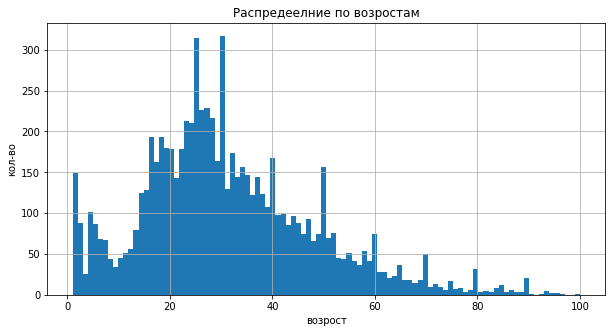

In [7]:
plt.figure(figsize=(10,5))
plt.xlabel('возрост')
plt.ylabel('кол-во')
plt.title('Распредеелние по возростам')

df['real_age'].hist(bins=100)

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [6]:
features, target = next(datagen_flow)

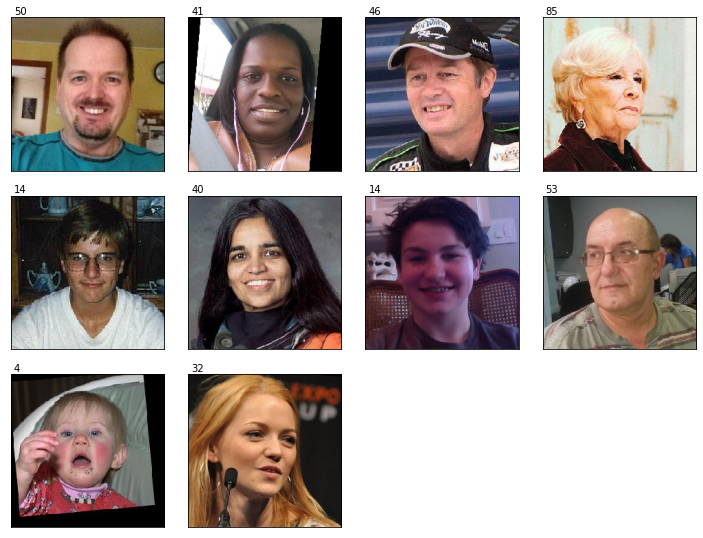

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text(4, -4, target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**

- Распределение возрастов покоже на нормальное со смещением вправо. 
- В выборке есть выбросы с возрастом менее 5 лет, для поставленной задачи желательно удалить. 
- В выборке недостаток фото людей пожилого возраста, значит модель будет менее точна на этой группе.
- Фото имеют разный фон, яркость и качество изображения, что может негативно повлиять на результаты модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

labels = pd.read_csv('/datasets/faces/labels.csv')


def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        validation_split=0.25,
        rescale=1./255)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow    


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

# < Epoch 5/5
356/356 - 91s - loss: 36.5778 - mae: 4.6268 - val_loss: 62.7260 - val_mae: 5.9837 >

# <475/475 - 45s - loss: 62.7260 - mae: 5.9837
Test MAE: 5.9837 >

```

## Анализ обученной модели

- На тестовой выборке минимальный mae 5.98, что лучше поставленного задачей.
- Необходимо добавить фото людей старше 40 лет
- Необходимо убрать фото детей младше 7 лет (для поставленных задач это выбросы)
- Необходимо убрать все изображения плохого качества 